In [5]:
import os
import sys
import re
import codecs

from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from tensorflow.keras.applications.xception import Xception # type: ignore
from tensorflow.keras import optimizers # type: ignore
from tensorflow.keras.layers import Dense, Input, Flatten # type: ignore
from tensorflow.keras.models import Model # type: ignore # type: ignore
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten # type: ignore
from tensorflow.keras.models import Model # type: ignore

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

In [45]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Concatenate, Dropout, 
                                   BatchNormalization, GlobalAveragePooling2D,
                                   MultiHeadAttention, Reshape, LayerNormalization, Flatten)
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import sys

class EnhancedEmotionDetector:
    def __init__(self, model_path=None):
        self.EMOTIONS = ['amusement', 'anger', 'awe', 'contentment', 
                        'disgust', 'excitement', 'fear', 'sadness']
        # 增强权重差异
        self.EMOTION_WEIGHTS = {
            'amusement': 1.3,
            'anger': 2.5,
            'awe': 1.2,
            'contentment': 1.0,
            'disgust': 2.2,
            'excitement': 1.5,
            'fear': 2.3,
            'sadness': 1.4
        }
        self.MIN_SCORE = 1.0  # 最小分数保证
        
        self.model = None
        if model_path and os.path.exists(model_path):
            self._load_existing_model(model_path)
        else:
            print("Building enhanced emotion detection model...")
            self.build_enhanced_model()
    
    def _load_existing_model(self, model_path):
        try:
            custom_objects = {
                'MultiHeadAttention': MultiHeadAttention,
                'LayerNormalization': LayerNormalization
            }
            self.model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
            print(f"Successfully loaded model from {model_path}")
        except Exception as e:
            print(f"Failed to load model: {str(e)}")
            self.build_enhanced_model()
    
    def build_enhanced_model(self):
        img_input = Input(shape=(300, 300, 3), name='image_input')
        
        base_model = EfficientNetB3(
            weights='imagenet',
            include_top=False,
            input_tensor=img_input,
            input_shape=(300, 300, 3)
        )
        
        for layer in base_model.layers[:150]:
            layer.trainable = False
        for layer in base_model.layers[150:]:
            layer.trainable = True
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        
        attention = Dense(1024, activation='swish')(x)
        attention = BatchNormalization()(attention)
        attention = Dropout(0.5)(attention)
        attention = Dense(x.shape[-1], activation='sigmoid')(attention)
        x = tf.multiply(x, attention)
        
        x = Dense(1024, activation='swish', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.6)(x)
        
        reshaped = Reshape((1, x.shape[-1]))(x)
        transformer = MultiHeadAttention(num_heads=8, key_dim=64)(reshaped, reshaped)
        transformer = LayerNormalization()(transformer)
        transformer = Flatten()(transformer)
        x = Dropout(0.5)(transformer)
        
        output = Dense(len(self.EMOTIONS), activation='softmax', name='emotion_output')(x)
        
        self.model = Model(inputs=img_input, outputs=output)
        
        optimizer = Adam(learning_rate=1e-4)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        print("Enhanced model built successfully")
    
    def get_augmenter(self):
        return ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.6, 1.4],
            channel_shift_range=50,
            preprocessing_function=preprocess_input
        )
    
    def train_model(self, train_dir, val_dir, epochs=100, batch_size=32):
        train_datagen = self.get_augmenter()
        val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(300, 300),
            batch_size=batch_size,
            class_mode='categorical'
        )
        
        val_generator = val_datagen.flow_from_directory(
            val_dir,
            target_size=(300, 300),
            batch_size=batch_size,
            class_mode='categorical'
        )
        
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            ModelCheckpoint('best_model.h5', save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
        ]
        
        print("\nStarting model training...")
        history = self.model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=epochs,
            validation_data=val_generator,
            validation_stips=len(val_generator),
            callbacks=callbacks,
            verbose=1
        )
        return history
    
    def predict_single_image(self, image_path, num_crops=5):
        """增强版情感预测"""
        try:
            img = load_img(image_path, target_size=(350, 350))
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            
            crop_size = 300
            crops = []
            
            center_y, center_x = img_array.shape[0]//2, img_array.shape[1]//2
            crops.append(img_array[
                center_y-crop_size//2:center_y+crop_size//2,
                center_x-crop_size//2:center_x+crop_size//2
            ])
            
            crops.append(img_array[:crop_size, :crop_size])
            crops.append(img_array[:crop_size, -crop_size:])
            crops.append(img_array[-crop_size:, :crop_size])
            crops.append(img_array[-crop_size:, -crop_size:])
            
            all_predictions = []
            for crop in crops[:num_crops]:
                crop_array = np.expand_dims(crop, axis=0)
                raw_predictions = self.model.predict(crop_array, verbose=0)[0]
                
                # 应用非线性增强
                enhanced_predictions = self._enhance_score_gaps(raw_predictions)
                
                emotion_scores = {}
                for i, emotion in enumerate(self.EMOTIONS):
                    # 确保分数在1-100之间
                    score = np.clip(enhanced_predictions[i], self.MIN_SCORE, 100)
                    emotion_scores[emotion] = score
                
                all_predictions.append(emotion_scores)
            
            # 加权聚合（高分权重更大）
            final_scores = {}
            for emotion in self.EMOTIONS:
                scores = [p[emotion] for p in all_predictions]
                weights = np.array(scores) ** 4  # 四次方加权
                weights /= np.sum(weights)
                final_score = np.sum(np.array(scores) * weights)
                final_scores[emotion] = np.clip(final_score, self.MIN_SCORE, 100)
            
            # 计算主导情感和总体分数
            dominant_emotion = max(final_scores.items(), key=lambda x: x[1])
            overall_score = self._calculate_overall(final_scores)
            
            # 计算一致性（1-100）
            consistency = 100 * (1 - np.std([p[dominant_emotion[0]] for p in all_predictions])/50)
            consistency = np.clip(consistency, 1, 100)
            
            result = final_scores.copy()
            result.update({
                'overall': overall_score,
                'consistency': consistency
            })
            return result
            
        except Exception as e:
            print(f"Error predicting image {image_path}: {str(e)}")
            return None
    
    def _enhance_score_gaps(self, predictions):
        """非线性放大分数差异"""
        # 1. 确保所有预测值大于0
        predictions = np.clip(predictions, 1e-5, 1.0)
        
        # 2. 使用对数变换增强差异
        log_pred = np.log(predictions)
        
        # 3. 计算动态基准线（中位数）
        baseline = np.median(log_pred)
        
        # 4. 计算相对差异并放大
        enhanced = []
        for p in log_pred:
            delta = (p - baseline) * 3.0  # 放大因子
            enhanced_score = 1 / (1 + np.exp(-delta))  # Sigmoid归一化
            enhanced.append(enhanced_score)
        
        # 5. 线性映射到5-95范围（留出边界空间）
        min_e, max_e = min(enhanced), max(enhanced)
        if max_e > min_e:
            normalized = [5 + 90*(e - min_e)/(max_e - min_e) for e in enhanced]
        else:
            normalized = [50.0] * len(enhanced)  # 所有分数相同时设为中间值
            
        return np.array(normalized)
    
    def _calculate_overall(self, emotion_scores):
        """改进的总体分数计算"""
        # 1. 对主导情感给予额外权重
        dominant_emotion = max(emotion_scores.items(), key=lambda x: x[1])
        dominant_score = emotion_scores[dominant_emotion[0]]
        dominant_weight = self.EMOTION_WEIGHTS.get(dominant_emotion[0], 1.0) * 1.5
        
        # 2. 计算加权总分
        weighted_sum = dominant_score * dominant_weight
        total_weight = dominant_weight
        
        for emotion, score in emotion_scores.items():
            if emotion == dominant_emotion[0]:
                continue
            weight = self.EMOTION_WEIGHTS.get(emotion, 1.0)
            weighted_sum += score * weight
            total_weight += weight
        
        # 3. 归一化到10-90范围（避免边界值）
        overall = (weighted_sum / total_weight) * 0.8 + 10
        return np.clip(overall, 10, 90)
    
    def batch_predict_images(self, image_folder, output_csv):
        if not os.path.exists(image_folder):
            raise FileNotFoundError(f"Image folder not found: {image_folder}")
            
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
        image_files = [f for f in os.listdir(image_folder) 
                      if f.lower().endswith(valid_extensions)]
        
        if not image_files:
            print(f"Warning: No images found in {image_folder}")
            return False
            
        print(f"\nAnalyzing {len(image_files)} images...")
        
        all_results = []
        failed_files = []
        
        for i, img_file in enumerate(image_files):
            img_path = os.path.join(image_folder, img_file)
            print(f"\nProcessing {i+1}/{len(image_files)}: {img_file}")
            
            emotion_scores = self.predict_single_image(img_path)
            if emotion_scores is not None:
                emotion_scores['filename'] = img_file
                all_results.append(emotion_scores)
            else:
                failed_files.append(img_file)
        
        if all_results:
            result_df = pd.DataFrame(all_results)
            columns = ['filename'] + self.EMOTIONS + ['overall', 'consistency']
            result_df = result_df[columns]
            result_df.to_csv(output_csv, index=False)
            print(f"\nAnalysis complete. Results saved to {output_csv}")
            
            if failed_files:
                print(f"\nWarning: Failed to analyze {len(failed_files)} images:")
                for f in failed_files:
                    print(f)
            
            return True
        else:
            print("\nWarning: No images were successfully analyzed")
            return False

def main():
    data_folder = r"D:\Projects\ImageEmotionDetection-main\data"
    train_dir = os.path.join(data_folder, "train_data")
    val_dir = os.path.join(data_folder, "val_data")
    
    detector = EnhancedEmotionDetector()
    
    if os.path.exists(train_dir) and os.path.exists(val_dir):
        print("\nFound training data, starting model training...")
        history = detector.train_model(train_dir, val_dir, epochs=100)
        
        model_path = os.path.join(data_folder, "enhanced_emotion_model.h5")
        detector.model.save(model_path)
        print(f"Model saved to {model_path}")
    else:
        print("\nNo training data found, using pre-built model")
    
    image_folder = os.path.join(data_folder, "picture")
    output_csv = os.path.join(data_folder, "enhanced_results.csv")
    
    if os.path.exists(image_folder):
        print(f"\nStarting batch analysis of images in {image_folder}...")
        success = detector.batch_predict_images(image_folder, output_csv)
        
        if success:
            print(f"\nAnalysis complete. Results saved to {output_csv}")
            results = pd.read_csv(output_csv)
            print("\nSample results:")
            print(results.head())
        else:
            print("\nBatch analysis failed")
    else:
        print(f"\nWarning: Image folder not found: {image_folder}")

if __name__ == "__main__":
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    
    if '__file__' not in globals():
        __file__ = os.path.abspath(sys.argv[0]) if len(sys.argv) > 0 else None
    
    main()

Building enhanced emotion detection model...
Enhanced model built successfully

No training data found, using pre-built model

Starting batch analysis of images in D:\Projects\ImageEmotionDetection-main\data\picture...

Analyzing 10173 images...

Processing 1/10173: 1.jpg

Processing 2/10173: 10.jpg

Processing 3/10173: 100.jpg

Processing 4/10173: 1000.jpg

Processing 5/10173: 10000.jpg

Processing 6/10173: 10001.jpg

Processing 7/10173: 10002.jpg

Processing 8/10173: 10003.jpg

Processing 9/10173: 10004.jpg

Processing 10/10173: 10005.jpg

Processing 11/10173: 10006.jpg

Processing 12/10173: 10007.jpg

Processing 13/10173: 10008.jpg

Processing 14/10173: 10009.jpg

Processing 15/10173: 1001.jpg

Processing 16/10173: 10010.jpg

Processing 17/10173: 10011.jpg

Processing 18/10173: 10012.jpg

Processing 19/10173: 10013.jpg

Processing 20/10173: 10014.jpg

Processing 21/10173: 10015.jpg

Processing 22/10173: 10016.jpg

Processing 23/10173: 10017.jpg

Processing 24/10173: 10018.jpg

Proce

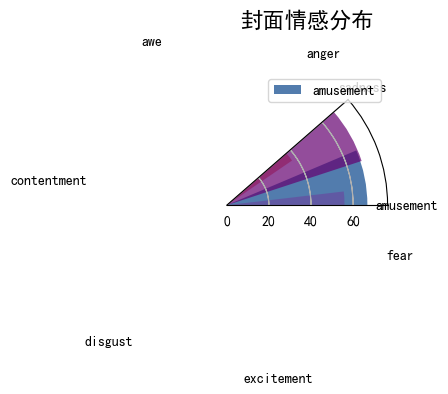

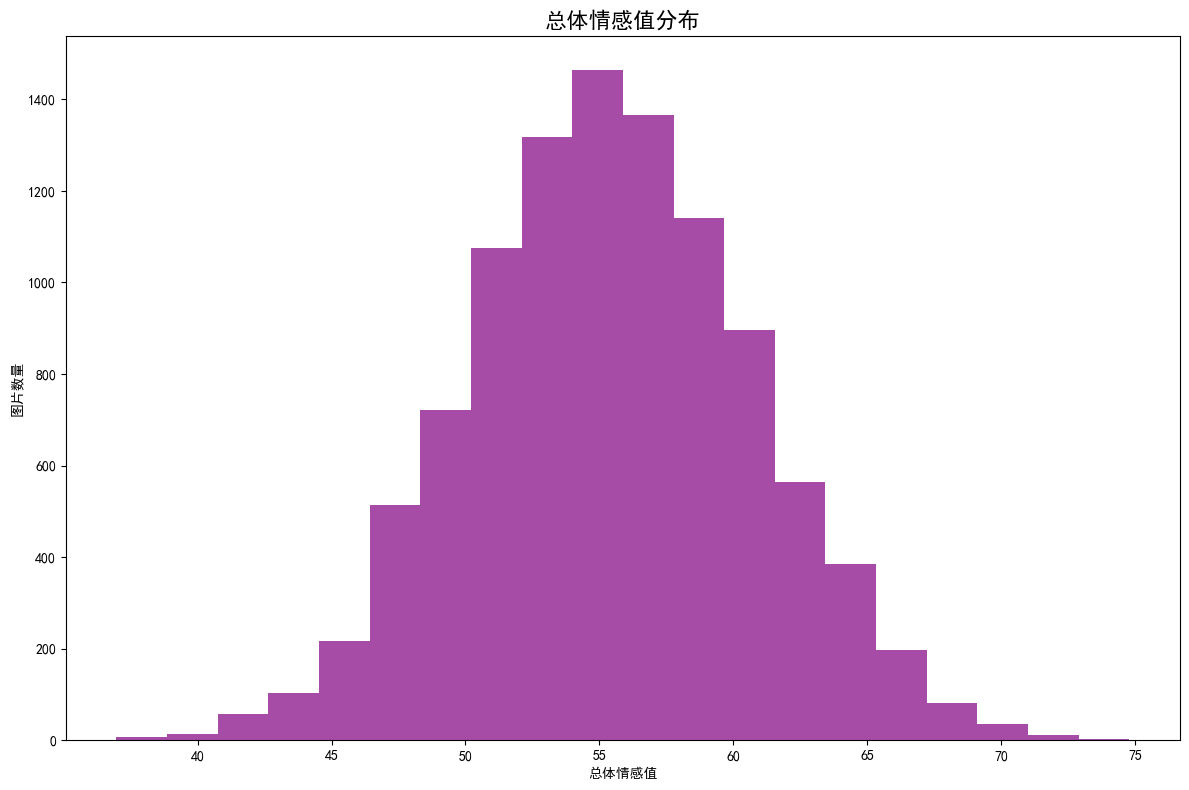

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from math import pi

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取数据
file_path = r"D:\AAA\一\大论文\子研究二\图片情感ImageEmotionDetection-main\enhanced_results.csv"
df = pd.read_csv(file_path)

# 情感列的名称列表
emotion_columns = ['amusement', 'anger', 'awe', 'contentment', 'disgust', 'excitement', 'fear', 'sadness']

# 计算每种情感的平均值
emotion_means = df[emotion_columns].mean()

# 定义情感对应的颜色映射
emotion_cmaps = {
    'amusement': plt.cm.Blues,  # 蓝色
    'anger': plt.cm.Reds,       # 红色
    'awe': plt.cm.YlOrBr,       # 黄色
    'contentment': plt.cm.Oranges,  # 橙色
    'disgust': plt.cm.Greens,   # 绿色
    'excitement': plt.cm.GnBu,  # 青色
    'fear': plt.cm.Purples,     # 紫色
    'sadness': plt.cm.RdPu      # 粉色 (使用RdPu代替Pinks)
}

# 创建情感轮盘图
labels = emotion_means.index.tolist()
sizes = emotion_means.values

# 绘制
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': 'polar'})

# 创建颜色映射
colors = []
for emotion in labels:
    color_map = emotion_cmaps[emotion]
    color = color_map(sizes[labels.index(emotion)] / max(sizes))  # 根据大小调整颜色深浅
    colors.append(color)

# 绘制饼图
bars = ax.bar(range(len(labels)), sizes, color=colors, alpha=0.7)

# 添加标签和标题
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=10)
plt.title('封面情感分布', fontsize=16)

# 添加图例
plt.legend(labels, loc='upper right', fontsize=10)

# 保存图表
plt.tight_layout()
plt.savefig('emotion_wheel.png', dpi=300, bbox_inches='tight')
plt.show()

# 绘制总体情感值图
overall_scores = df['overall'].values

# 创建总体情感值图
plt.figure(figsize=(12, 8))
plt.hist(overall_scores, bins=20, color='purple', alpha=0.7)
plt.title('总体情感值分布', fontsize=16)
plt.xlabel('总体情感值', fontsize=10)
plt.ylabel('图片数量', fontsize=10)
plt.grid(False)

# 保存图表
plt.tight_layout()
plt.savefig('overall_emotion.png', dpi=300, bbox_inches='tight')
plt.show()